In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# For Sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
cd ..


/Users/amandabuch/Documents/clusterCCA/PCMF


In [3]:
import os
os.chdir('experiments/icml-2022')
from path_fits import fit_spectral, fit_dpgmm


In [4]:
cd ..

/Users/amandabuch/Documents/clusterCCA/PCMF


In [5]:
def centroid_matrix(X,labels):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    keys, counts = np.unique(labels, return_counts=True)
    for k in keys:
        centroid_dict[k] = list() # np.zeros(X.shape[1])
    for i,l in enumerate(labels):
        centroid_dict[l].append(X[i,:])
    for j,k in enumerate(keys):
        centroid_dict[k] = np.mean(np.asarray(centroid_dict[k]), axis=0)
    for i,l in enumerate(labels):
        X_out[i,:] = centroid_dict[l]
    return X_out

def centroid_matrix_mixture(X,proba,means):
    '''
    Given a matrix X and labels clustering each of it's rows, return a matrix 
    where each row has been replaced by it's nearest centroid.
    '''
    centroid_dict = dict()
    X_out = np.zeros_like(X)
    for i in range(X_out.shape[0]):
        X_out[i,:] = np.dot(proba[i],means)
    return X_out

########### Model Selection functions ############
def cluster_fit(Xhat, num_clusters=2, gamma=2.0,  method='spectral'):
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        # clustering = SpectralClustering(n_clusters = num_clusters, gamma=gamma, \
                                        # assign_labels='discretize',affinity='rbf')
        clustering = SpectralClustering(n_clusters=num_clusters, random_state=0, gamma=gamma).fit(Xhat)
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=num_clusters, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=num_clusters, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    return clustering.labels_

def select_fit(n_clusts, ics, num_clusters):
    start_num = np.where(np.array(n_clusts)==num_clusters)[0]
    if len(start_num) > 1:
        start_num = start_num[0]
    vals = np.array(ics)[np.where(np.array(n_clusts)==num_clusters)]
    idxs = np.where(vals == np.min(vals))[0]
    if len(idxs) > 1:
        idxs = idxs[0]
    return start_num + idxs

def cluster_path(X_c, Xhat_list, penalty_list, gauss_coef, neighbors, verbose=False):
    '''
    Estimate number of clusters and fit quality at each value of the penalty.
    '''
    ics = []
    n_clusts = []
    centroids = []
    n_clust = 1
    D = sparse_D(X_c.shape[0],X_c.shape[1])
    weights = get_weights(X_c, gauss_coef=gauss_coef, neighbors=neighbors)
    #
    notinf_idx = np.where(np.asarray(penalty_list)<np.inf)[0]
    penalty_list = penalty_list[notinf_idx]
    Xhat_list = [Xhat_list[i] for i in range(len(Xhat_list)) if i in notinf_idx]
    for i,Xhat in enumerate(Xhat_list):
        penalty = penalty_list[i]
        if n_clust < Xhat.shape[0]:
            out, n_clust, labels, ic = cluster_forwardstep(Xhat, X_c, D, n_clust, penalty, weights, 
                                                            method='spectral', gamma=gauss_coef, selection='lik', verbose=verbose)
        n_clusts.append(n_clust)
        ics.append(ic)
        centroids.append(out)
    return n_clusts, ics, centroids

from p3ca import convex_clust_df
def cluster_forwardstep(Xhat, X, D, n_clust_previous, penalty, weights, method='spectral', gamma=1.0, selection='bic', verbose=False):
    epsilon = penalty
    #
    # Cluster on the rows of Xhat with k=n_clust_previous
    if method == 'spectral':
        clustering = SpectralClustering(n_clusters = n_clust_previous, gamma=gamma, \
                                        assign_labels='discretize',affinity='rbf')
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=n_clust_previous, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clust_previous, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    labels1 = clustering.labels_
    Xhat1 = centroid_matrix(Xhat, labels1)
    df1 = n_clust_previous + 2
    #df1 = convex_clust_df(Xhat1, penalty, epsilon = epsilon)  
    if np.isnan(df1):
        df1 = 1
    #print('DF1:',df1, n_clust_previous)
    #
    # Cluster on the rows of V with k=n_clust_previous+1 
    if method == 'spectral':
        clustering = SpectralClustering(n_clusters = n_clust_previous+1, gamma=gamma, \
                                        assign_labels='discretize',affinity='rbf')
    elif method == 'kmeans':
        clustering = KMeans(n_clusters=n_clust_previous+1, random_state=0)
    elif method == 'gmm':
        clustering = GaussianMixture(n_components=n_clust_previous+1, warm_start=True)
    else:
        return ValueError('Selected clustering method not yet implemented.')
    clustering.fit(Xhat)
    #
    labels2 = clustering.labels_
    Xhat2 = centroid_matrix(Xhat, labels2)
    df2 = n_clust_previous + 1 + 2
    #df2 = convex_clust_df(Xhat2, penalty, epsilon = epsilon)      
    if np.isnan(df2):
        df2 = 2
    #print('DF2:',df2,n_clust_previous+1)
    #
    # Check loss for both clusterings
    loglik1 = np.linalg.norm(X - Xhat1, 2)**2 + penalty*np.sum(weights*np.sum(np.abs(D*Xhat1),axis=1))
    loglik2 = np.linalg.norm(X - Xhat2, 2)**2 + penalty*np.sum(weights*np.sum(np.abs(D*Xhat2),axis=1))
    #
    if selection == 'aic':
        ic1 = loglik1 + 2*df1 
        ic2 = loglik2 + 2*df2 
    elif selection == 'bic':
        ic1 = loglik1 + df1*np.log(Xhat.shape[0])
        ic2 = loglik2 + df2*np.log(Xhat.shape[0])
    else:
        ic1 = loglik1
        ic2 = loglik2
    #
    if verbose:
        print("IC1, IC2, Penalty, Penalty Term:",ic1,ic2,penalty,np.sum(weights*np.sum(np.abs(D*Xhat2),axis=1)))
    if np.isnan(ic1):
        ic1 = np.inf
    #
    # Return the better clustering 
    if ic1 >= ic2:
        if verbose:
            print('Num clusters:', n_clust_previous+1)
        return centroid_matrix(Xhat,labels2), n_clust_previous+1, labels2, ic2
    else:
        if verbose:
            print('Num clusters:', n_clust_previous)
        return centroid_matrix(Xhat,labels1), n_clust_previous, labels1, ic1

def convex_clust_df(uV, penalty, epsilon = 0.75):
    D = sparse_D(uV.shape[0], uV.shape[1])
    zero_idxs = np.where(np.sum(np.abs(D*uV),axis=1) <= epsilon)[0]

    D0 = D[zero_idxs,:]
    D1 = D[[i for i in range(D.shape[0]) if i not in zero_idxs],:]

    chol_D0 = cholesky_AAt(D0, beta=1.0)
    I = np.eye(D.shape[1])
    P = I - D0.T * chol_D0(D0)

    LHS = (1.0/np.linalg.norm(D1*uV)) * (D1.T * D1)
    RHS = (1.0/np.linalg.norm(D1*uV)**3) * ((D1.T*D1)*np.dot(uV, uV.T)*(D1.T*D1))

    df_hat = np.trace(np.linalg.inv(I + penalty*P*(LHS - RHS)) * P)
    return df_hat

In [6]:
from pcmf import pcmf_full, pcmf_approx_uV, pcmf_full_consensus, save_multi_image, two_cluster_data, generate_cluster_PMD_data
def load_experiments(data_path, pcmf_type, data_type, r=7, m=5, n_clusters=20):
    results = np.load(data_path, allow_pickle=True)
    gauss_coef = float(results['gauss_coef'])
    neighbors = int(results['neighbors'])
    penalty_list = list(results['penalty_list'])
    if data_type == 'numerical':
        means = [-5.2, 5.2, -4.8, 4.8, -4.1, 4.1, -3.7, 3.7, -3.1, 3.1,-2.8, 2.8, -2.1, 2.1, -1.5, 1.5, -1.0, 1.0, -0.4, 0.4]
        sigma = results['sigma']
        seeds = results['seeds']
        scale_data = results['scale_data'] # True
        intercept = results['intercept']
        ms = [m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m]
        num_vars = results['n_X']
        density = results['density']
        X_clusters, u_true, v_true, _=generate_cluster_PMD_data(ms, num_vars, sigma, density, n_clusters, means=means) 
        X=np.vstack(X_clusters)
        np.random.seed(seed=1234)
        idx_perm=np.random.permutation(X.shape[0])
        X=X[idx_perm,:]
#         true_clusters = results['true_clusters']
        true_clusters=np.repeat([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],m)
        true_clusters=true_clusters[idx_perm]

    else:
        X = results['X_c']
        true_clusters = results['true_clusters']
     #
    # if dataset=='_SRBCT_genomics':
    #     idx_keep = ~np.isnan(true_clusters)
    #     true_clusters = true_clusters[idx_keep]
    if pcmf_type == 'pcmf_full':
        A = results['A']
        Xhat_list = A
    elif pcmf_type == 'pcmf_approx_uV':
        U = results['U']
        V = results['V']
        Xhat_list = []
        #
        for i in range(len(penalty_list)):
            Xhat_list.append(U[i] * V[i])
    elif pcmf_type == 'pcmf_full_consensus':
        A = results['A']
        Xhat_list = A
    else:
        print('Incorrect pcmf_type')
    #
    return X, Xhat_list, true_clusters, results, u_true, v_true

def fit_pcmf(X, true_clusters, n_clusters, gauss_coef, c_method='spectral'):
    '''PCMF spectral clustering'''
    from sklearn.cluster import SpectralClustering
    #
    data_in = X
    #
    labels = cluster_fit(X, num_clusters=n_clusters, gamma=gauss_coef, method=c_method)
    #
    # Calculate scores
    nmi, ari, ri, mse = calculate_scores_nonpath(labels, true_clusters)
    # Calculate accuracy
    conf_mat_ord = confusion_matrix_ordered(labels,true_clusters)
    acc = np.sum(np.diag(conf_mat_ord))/np.sum(conf_mat_ord)
    #
    return labels, ari, nmi, acc

from sklearn.cluster import SpectralClustering
def confusion_matrix_ordered(pred, true):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))
    js = [e for e in sorted(indexes, key=lambda x: x[0])[1]]
    conf_mat_ord = conf_mat[:, js]
    return conf_mat_ord

def path_plot(coefficient_arr, penalty_list,plot_range=[0,-1], cut_vars=False, first_vars_only=False, var_sel=1):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]
        
    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap
    cmap = cm.get_cmap('viridis', coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[2]))

    # Define x-axis range
    penalty_range = range(len(penalty_list))

    fig, ax = plt.subplots(1,1, figsize=(20,10))
    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.15)
        ax.set_xticks(range(x.shape[0]), minor=False);
        ax.set_facecolor('white')
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_xticklabels(x,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.tick_params(axis='y', labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=24)
    plt.ylabel('Coefficients',fontsize=24)



In [7]:
data_path = 'data/pcmf_full_consensus_synthetic_run7_div_consensusComparison_20Classes_n1000_p100_density0.5_split_size_100_gausscoef5.0_neighbors50_admm_iters20_rho1.0.npz'
print(data_path)
X, Xhat_list, true_clusters, results, u_true, v_true = load_experiments(data_path, 'pcmf_full_consensus', 'numerical', r=7, m=50)
print(X.shape, Xhat_list.shape)
penalty_list=results['penalty_list']

true_clusters = results['true_clusters']
p=58 # penalty



data/pcmf_full_consensus_synthetic_run7_div_consensusComparison_20Classes_n1000_p100_density0.5_split_size_100_gausscoef5.0_neighbors50_admm_iters20_rho1.0.npz
(1000, 100) (60, 1000, 100)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

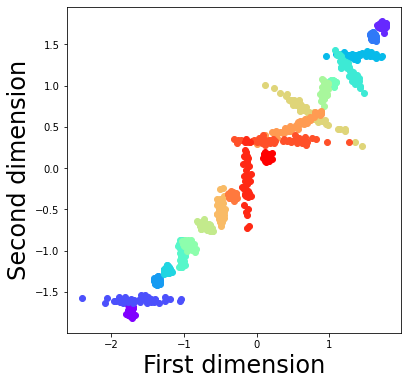

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm

plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set(facecolor = "white")
plt.xlabel('First dimension',fontsize=24)
plt.ylabel('Second dimension',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in range(20):
    plt.scatter(X[true_clusters==i,0],X[true_clusters==i,1], c=colors[i])


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

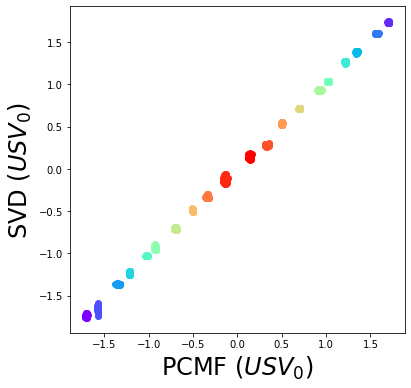

In [9]:
import os
from sklearn.utils.extmath import randomized_svd

from path_fits import fit_spectral, fit_dpgmm

plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set(facecolor = "white")
plt.xlabel('PCMF (${USV_0}$)',fontsize=24)
plt.ylabel('SVD (${USV_0}$)',fontsize=24)
colors = cm.rainbow(np.linspace(0, 1, 20))
for i in np.arange(20):
    inds = (results['true_clusters']==i)
    # Compute SVD for first component with cluster (no recentering):
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)
    
#     For PCMF, recalculate S within cluster using only the X/U in the cluster:
    SS = (results['U'][p].T@X)@results['V'][p].T
    
    plt.scatter(results['A'][p][inds,0:1], (U@V*S)[:,0:1], c=colors[i])


In [10]:
# UPDATING PCMF:
# Reset V to be what is capturing sign differences (important due to sign ambiguity between U and V)
Vv=np.tile(results['V'][p],(X.shape[0],1))*np.sign(results['U'][p])

U_pcmf_cluster=np.zeros((X.shape[0],1))
V_pcmf_cluster=np.zeros((20,X.shape[1]))
S_pcmf_cluster=np.zeros((20,1))
U_SVD_cluster=np.zeros((X.shape[0],1))
V_SVD_cluster=np.zeros((20,X.shape[1]))
S_SVD_cluster=np.zeros((20,1))
for m in range(20):
    # Get indices to subjects in cluster m
    inds = true_clusters==m
    
    # UPDATING PCMF WITHIN CLUSTER:
    # Set all PCMFV to be the same within that cluster
    V_pcmf_cluster[m,:] = np.mean(Vv[inds,:])
    
    # Set U to magnitude since we reset V to be what is capturing sign differences
    Uu = np.abs(results['U'][p][inds])
    
    # For PCMF U within cluster m, normalize to unit vector
    U_pcmf_cluster[inds] = np.sqrt(1./np.sum(Uu**2))*Uu # Unit vector
    
    # Recalculate PCMF S within cluster using normalized U
    S_pcmf_cluster[m] = U_pcmf_cluster[inds].T@X[inds,:]@V_pcmf_cluster[m,:].T
    
    # CALCULATING STANDARD SVD WITHIN CLUSTER
    # Calculate standard SVD for 1st component within cluster m
    U, S, V = randomized_svd(X[inds,:], n_components=1,random_state=1234)

    U_SVD_cluster[inds] = U
    S_SVD_cluster[m] = S
    V_SVD_cluster[m,:] = V
    
print('S_PCMF:',S_pcmf_cluster.T)
print('S_SVD:',S_SVD_cluster.T)
print('')
print('U_PCMF[0:20]:',U_pcmf_cluster[0:20].T)
print('U_SVD[0:20]:',U_SVD_cluster[0:20].T)
print('')
print('V_PCMF[0:3,0:10].flatten():',V_pcmf_cluster[0:3,0:10].flatten() )
print('V_SVD[0:3,0:10].flatten():', V_SVD_cluster[0:3,0:10].flatten() )
print('')
print('PCMF S within clusters is equal to SVD S within clusters:', np.alltrue(np.round(S_pcmf_cluster,0)==np.round(S_pcmf_cluster,0)))
print('PCMF U within clusters is equal to SVD U within clusters:', np.alltrue(np.round(U_pcmf_cluster,2)==np.round(U_SVD_cluster,2)))
print('PCMF V within clusters is equal to SVD V within clusters:', np.alltrue(np.round(V_pcmf_cluster,1)==np.round(V_SVD_cluster,1)))



S_PCMF: [[122.7489594  122.51483738 113.51314917 113.17124045  96.67988793
   96.66490898  87.13442389  87.05186043  73.09535514  73.10431325
   66.03112251  66.04870264  49.56305176  49.50402094  35.35958736
   35.41437529  23.60209159  23.63680999   9.36090904   9.46755476]]
S_SVD: [[122.75708905 122.52107857 113.53894176 113.17452711  96.68656371
   96.66914851  87.14157673  87.06968987  73.09761215  73.11329109
   66.04288035  66.06145787  49.57601719  49.5076405   35.36896236
   35.43270253  23.62667492  23.68122636   9.5595828    9.58991994]]

U_PCMF[0:20]: [[0.14114297 0.13689967 0.1423836  0.14016947 0.14233606 0.14087278
  0.13988698 0.14050712 0.14367826 0.14144263 0.14316287 0.14090755
  0.14288691 0.14102392 0.13682583 0.14065997 0.14140256 0.14168641
  0.139949   0.1406023 ]]
U_SVD[0:20]: [[0.14199864 0.13656378 0.14118451 0.13661766 0.14156206 0.14167401
  0.14148534 0.14232095 0.14169323 0.14180113 0.14490333 0.14169958
  0.14855713 0.14107717 0.11551784 0.1411955  0.141

In [11]:
sgn = np.ones((len(penalty_list), 1000))
s = np.sign(np.array(results['U'])[59,:]).T[0].T

sgn = np.tile(s,(len(penalty_list),1))
print(sgn.shape)
for p in range(len(penalty_list)):
    tr = np.where((np.sign(np.array(results['U'])[10,:]) != np.sign(np.array(results['U'])[59,:]).T)[0])
    sgn[p,tr] = np.atleast_2d(np.sign(np.array(results['U'])[59,tr[0]])).T
sgn.shape = (60,1000,1)

(60, 1000)


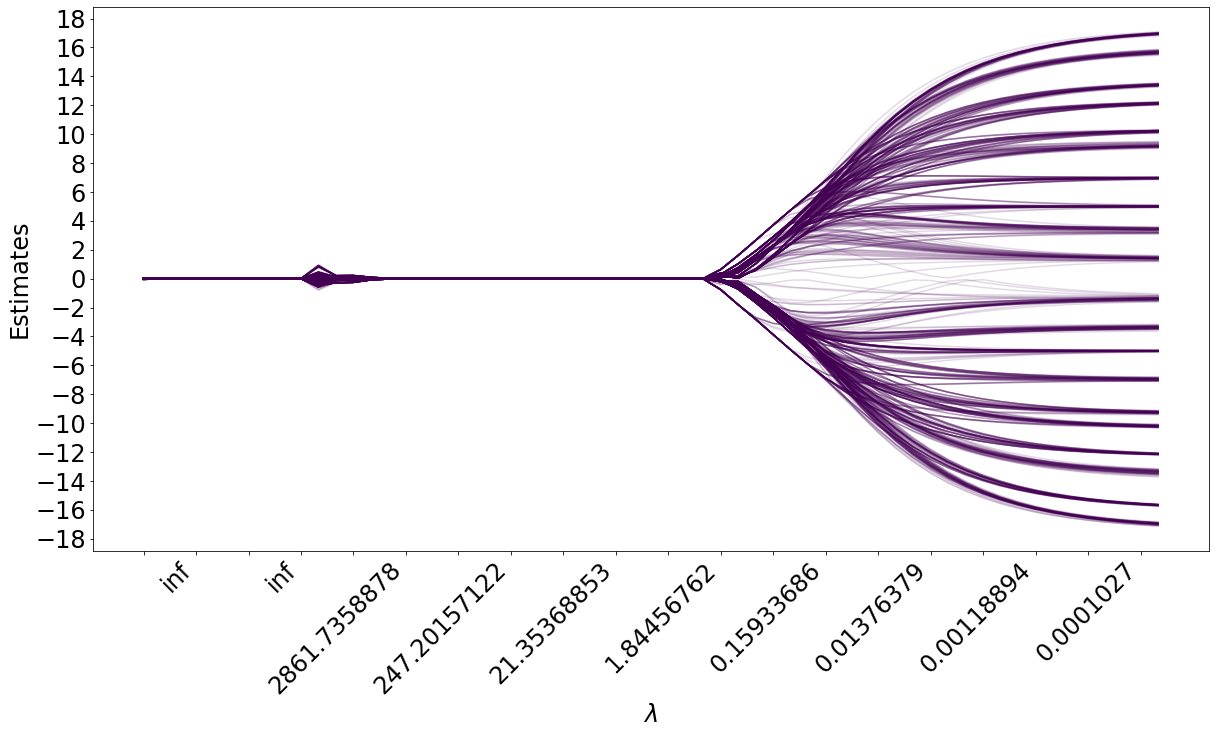

In [12]:
path_plot(sgn*np.abs(np.array(results['U'])[:,:])*np.array(results['S']), penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)


Best IDX 59 ACC: 1.0 ARI: 1.0 NMI: 1.0


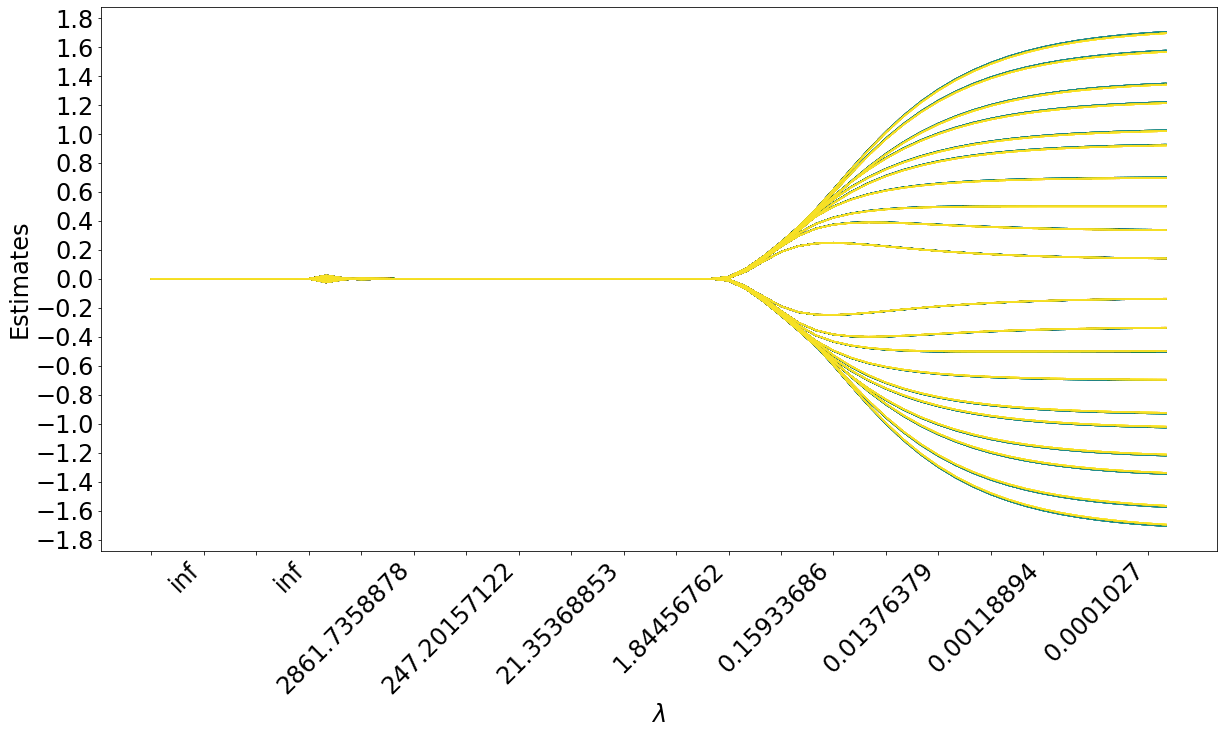

In [13]:
from p3ca import cluster_metrics, calculate_scores_nonpath
import time
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

centroids = []
# p=55
labels, ari, nmi, acc = fit_pcmf(Xhat_list[p], true_clusters, 20, results['gauss_coef'])

print('Best IDX',p,'ACC:',acc,'ARI:',ari,'NMI:',nmi)
for p in range(len(penalty_list)):
    centroids.append(centroid_matrix(np.array(Xhat_list[p]),labels))

path_plot(np.asarray(centroids)[:,:,0:3], penalty_list, plot_range=[0,-1])
plt.ylabel("Estimates")
plt.locator_params(nbins=25)
